# README FILE
## Data loader
This part is basically the same as before. I apply normalization based on the training set, and the normalized values are applied to all training, validating,
and testing dataset.

I also include some random Gaussian Noise to the inputs. I pick 5% of inputs and add a Normal(0, 0.1) noise to every vector of it.


## Model architecture (Listener)
I had 4 layers of CNN (with 2 residue connection), 4 layers of LSTM (including 2 layers of BLSTM and 2 layers of pBLSTM), and finally 3 layers of MLP. The width of my neural network is not so big, but I think it's pretty deep.

I also get the LockedDropout implementation, although I don't think it turns out to be better than normal dropout.


## Model architecture (Attention)
For attention we basically follow the instructions given. Note that we may need to squeeze and unsqueeze to make the dimensions right for bmm


## Model architecture (Speller)
Similar to HW4P1

# HW4P2: Attention-based Speech Recognition

<img src="https://cdn.shopify.com/s/files/1/0272/2080/3722/products/SmileBumperSticker_5400x.jpg" alt="A cute cat" width="600">


Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with <i>attention</i>. <br> <br>

<center>
<img src="https://popmn.org/wp-content/uploads/2020/03/pay-attention.jpg" alt="A cute cat" height="100">
</center>

HW Writeup: On Piazza/Course Website <br>
Kaggle Competition Link: https://www.kaggle.com/competitions/11-785-s23-hw4p2/ <br>
Kaggle Dataset Link: https://www.kaggle.com/datasets/varunjain3/11-785-s23-hw4p2-dataset
<br>
LAS Paper: https://arxiv.org/pdf/1508.01211.pdf <br>
Attention is all you need:https://arxiv.org/pdf/1706.03762.pdf

# Read this section importantly!

1. By now, we believe that you are already a great deep learning practitioner, Congratulations. 🎉

2. You are allowed to use code from your previous homeworks for this homework. We will only provide, aspects that are necessary and new with this homework.

3. There are a lot of resources provided in this notebook, that will help you check if you are running your implementations correctly.

# Imports

In [14]:
# Import Necessary Modules you require for this HW here
import torch
import torch.nn as nn
import numpy as np
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import wandb
import os
import Levenshtein
from tqdm import tqdm
import gc
import torchnlp
from matplotlib import pyplot as plt
import time
import seaborn as sns
import torchaudio.transforms as tat
import random
from torchnlp.nn import LockedDropout

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda:0


# Toy Dataset Download

In [15]:
# !wget -q https://cmu.box.com/shared/static/om4qpzd4tf1xo4h7230k4v1pbdyueghe --content-disposition --show-progress
# !unzip -q hw4p2_toy.zip -d ./

# Dataset and Dataloaders

We have given you 2 datasets. One is a toy dataset, and the other is the standard LibriSpeech dataset. The toy dataset is to help you get your code implemented and tested and debugged easily, to verify that your attention diagonal is produced correctly. Note however that it's task (phonetic transcription) is drawn from HW3P2, it is meant to be familiar and help you understand how to transition from phonetic transcription to alphabet transcription, with a working attention module.

Please make sure you use the right constants in your code implementation for future modules, (SOS_TOKEN vs SOS_TOKEN_TOY) when working with either dataset. We have defined the constants accordingly below. Before you come to OH or post on piazza, make sure you aren't misuing the constants for either dataset in your code.

## Toy Dataset

The toy dataset is a dataset of fixed length speech sequences that have phonetic transcripts. The reason we made it with phonetic transcripts was to help you understand how attention can work with phonetic transcription that you have done in HW3P2

In [16]:
config = {
  'batch_size': 128,
  'lr':1e-3,
  'epochs': 60,
  'frac' : 1,
  'training' : False,
  "dropout" : False,
  "dbg1" : False,
  'dbg2' : False,
  'epoch' : 0
}

In [17]:
VOCAB = ['<pad>', '<sos>', '<eos>',
         'A',   'B',    'C',    'D',
         'E',   'F',    'G',    'H',
         'I',   'J',    'K',    'L',
         'M',   'N',    'O',    'P',
         'Q',   'R',    'S',    'T',
         'U',   'V',    'W',    'X',
         'Y',   'Z',    "'",    ' ',
         ]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of vocab: {len(VOCAB)}")
print(f"Vocab: {VOCAB}")
print(f"PAD_TOKEN: {PAD_TOKEN}")
print(f"SOS_TOKEN: {SOS_TOKEN}")
print(f"EOS_TOKEN: {EOS_TOKEN}")

Length of vocab: 31
Vocab: ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN: 0
SOS_TOKEN: 1
EOS_TOKEN: 2


In [18]:
class SpeechTrainDataset(torch.utils.data.Dataset):
  '''
  Feel free to add arguments, additional functions, this is the
  bare-minimum template.
  '''
  def __init__(self, root, vocab = VOCAB_MAP,
                 partition = "train-clean-100", frac = 1):
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        # Load the directory and all files in them
        # PHONEMES & LABELS

        self.mfcc_dir = os.path.join(root, partition, 'mfcc/')
        self.transcript_dir = os.path.join(root, partition, 'transcripts/')

        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))
        self.transcript_files = sorted(os.listdir(self.transcript_dir))

        # for clearn-460 uncomment this
        # self.mfcc_dir2 = os.path.join(root, "train-clean-100", 'mfcc/')
        # self.transcript_dir2 = os.path.join(root, "train-clean-100", 'transcript/')

        # self.mfcc_files2 = sorted(os.listdir(self.mfcc_dir2))
        # self.transcript_files2 = sorted(os.listdir(self.transcript_dir2))

        self.vocab = vocab

        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        # self.length = (len(self.mfcc_files) + len(self.mfcc_files2)) // frac
        self.length = len(self.mfcc_files) // frac

        self.mfccs, self.transcripts = [], []
        tot_mfcc = 0
        tot_trans = 0


        for i in range(len(self.mfcc_files) // frac):
            mfcc = np.load(self.mfcc_dir + self.mfcc_files[i])
            mfcc = (mfcc - np.mean(mfcc, axis = 0)) / np.std(mfcc, axis = 0)
            tot_mfcc += mfcc.shape[0]
            transcript  = np.load(self.transcript_dir + self.transcript_files[i])
            transcript = [self.vocab[i] for i in transcript]
            tot_trans += len(transcript)
            self.mfccs.append(mfcc)
            self.transcripts.append(transcript)
        print("train / valid")
        print(tot_mfcc / self.length)
        print(tot_trans / self.length)

  def __len__(self):
    return self.length

  def __getitem__(self, ind):
    mfcc = torch.tensor(self.mfccs[ind])
    # uncomment if need noise
    # if (np.random.randint(100) < 5):
    #     torch.add(mfcc, torch.normal(0, 0.1, size=mfcc.shape))
    transcript = torch.tensor(self.transcripts[ind])
    return mfcc, transcript

  def collate_fn(self, batch):
    # batch of input mfcc coefficients
        batch_mfcc = [mfcc[0] for mfcc in batch]
        # batch of output phonemes
        batch_transcript = [mfcc[1] for mfcc in batch]

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first = True)
        lengths_mfcc = [len(mfcc) for mfcc in batch_mfcc]

        batch_transcript_pad = pad_sequence(batch_transcript, batch_first = True)
        lengths_transcript = [len(transcript) for transcript in batch_transcript]

        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?

        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

In [19]:
class SpeechTestDataset(torch.utils.data.Dataset):
  '''
  Feel free to add arguments, additional functions, this is the
  bare-minimum template.
  '''
  def __init__(self, root, vocab = VOCAB_MAP,
                 partition = "test-clean", frac = 1):
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        # Load the directory and all files in them
        # PHONEMES & LABELS

        self.mfcc_dir = os.path.join(root, partition, 'mfcc/')
        # self.transcript_dir = os.path.join(root, partition, 'transcript/')

        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))
        # self.transcript_files = sorted(os.listdir(self.transcript_dir))

        # for clearn-460 uncomment this
        # self.mfcc_dir2 = os.path.join(root, "train-clean-100", 'mfcc/')
        # self.transcript_dir2 = os.path.join(root, "train-clean-100", 'transcript/')

        # self.mfcc_files2 = sorted(os.listdir(self.mfcc_dir2))
        # self.transcript_files2 = sorted(os.listdir(self.transcript_dir2))

        self.vocab = vocab

        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        # self.length = (len(self.mfcc_files) + len(self.mfcc_files2)) // frac
        self.length = len(self.mfcc_files) // frac

        self.mfccs, self.transcripts = [], []
        tot_mfcc = 0

        for i in range(len(self.mfcc_files) // frac):
            mfcc = np.load(self.mfcc_dir + self.mfcc_files[i])
            mfcc = (mfcc - np.mean(mfcc, axis = 0)) / np.std(mfcc, axis = 0)
            tot_mfcc += mfcc.shape[0]
            # transcript  = np.load(self.transcript_dir + self.transcript_files[i])
            # transcript = [self.vocab[i] for i in transcript]
            self.mfccs.append(mfcc)
            # self.transcripts.append(transcript)

        print("test")
        print(tot_mfcc / self.length)


  def __len__(self):
    return self.length

  def __getitem__(self, ind):
    mfcc = torch.tensor(self.mfccs[ind])
    return mfcc

  def collate_fn(self, batch):
    # batch of input mfcc coefficients
        batch_mfcc = batch

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first = True)
        lengths_mfcc = [len(mfcc) for mfcc in batch_mfcc]

        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?

        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, torch.tensor(lengths_mfcc)

In [20]:
# get me RAMMM!!!!
import gc
gc.collect()

root = 'data/11-785-f23-hw4p2'

train_dataset = SpeechTrainDataset(root, partition = 'train-clean-100', frac = config['frac'])
val_dataset = SpeechTrainDataset(root, partition = 'dev-clean')
test_dataset = SpeechTestDataset(root, partition = 'test-clean')

train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    num_workers = 8,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = True,
    collate_fn = train_dataset.collate_fn
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_dataset,
    num_workers = 4,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False,
    collate_fn = val_dataset.collate_fn
)

test_loader = torch.utils.data.DataLoader(
    dataset     = test_dataset,
    num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False,
    collate_fn = test_dataset.collate_fn
)

print("\nChecking the shapes of the data...")
for batch in val_loader:
    x, y, x_len, y_len = batch
    print(x.shape, y.shape, x_len.shape, y_len.shape)
    break

train / valid
1264.6258453344547
186.65321139493324
train / valid
713.3570107288198
108.71698113207547
test
738.2206106870229

Checking the shapes of the data...
torch.Size([128, 2936, 28]) torch.Size([128, 364]) torch.Size([128]) torch.Size([128])


## The Listener:

In [21]:
# Utils for network
torch.cuda.empty_cache()

class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

def Drop(training, Epoch):
    if (training == False):
        return 0.0
    if Epoch < 5:
        return 0.03 * (epoch + 1)
    return 0.15 / ((Epoch + 8) / 13)

class pBLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, down = False):
        super(pBLSTM, self).__init__()
        self.dropout = 0
        self.down = down
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blstm = nn.LSTM(input_size, hidden_size, bidirectional = True, dropout = 0.05)

    def forward(self, x_packed): # x_packed is a PackedSequence
        self.dropout = Drop(config['training'], config['epoch'])
        # TODO: Pad Packed Sequence
        (x_pad, x_len) = pad_packed_sequence(x_packed, batch_first = True)
        if (config['training']):
            x_pad = lockeddropout(self.dropout)(x_pad)
        if self.down:
            (x_reshape, x_len_reshape) = self.trunc_reshape(x_pad, x_len)
        else:
            (x_reshape, x_len_reshape) = (x_pad, x_len)

        final = pack_padded_sequence(x_reshape, x_len_reshape, batch_first = True, enforce_sorted=False)
        value, _ = self.blstm(final)
        return value

    def trunc_reshape(self, x, x_lens):
        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        if x.shape[1] % 2 != 0:
            x = x[:, :-1, :]
            x_lens = x_lens - 1
        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        x = x.reshape(x.shape[0], x.shape[1] // 2, x.shape[2] * 2)
        # TODO: Reduce lengths by the same downsampling factor
        x_lens = x_lens // 2
        return x, x_lens

class lockeddropout(nn.Module):
    """ LockedDropout applies the same dropout mask to every time step.

    **Thank you** to Sales Force for their initial implementation of :class:`WeightDrop`. Here is
    their `License
    <https://github.com/salesforce/awd-lstm-lm/blob/master/LICENSE>`__.

    Args:
        p (float): Probability of an element in the dropout mask to be zeroed.
    """

    def __init__(self, p=0.5):
        self.p = p
        super().__init__()

    def forward(self, x):
        """
        Args:
            x (:class:`torch.FloatTensor` [sequence length, batch size, rnn hidden size]): Input to
                apply dropout too.
        """
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(x.shape[0], 1, x.shape[2], requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        return x * mask


    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'p=' + str(self.p) + ')'

In [22]:
class Listener(torch.nn.Module):
  def __init__(self, input_size, encoder_hidden_size):
    super(Listener, self).__init__()
    # self.dropout = 0
    self.input_size = input_size
    self.encoder_hidden_size = encoder_hidden_size
    # print("?????????????????????????????????????????????")

    #TODO: You can use CNNs as Embedding layer to extract features. Keep in mind the Input dimensions and expected dimension of Pytorch CNN.
    self.embedding1 = nn.Sequential(
        nn.Conv1d(input_size, 128, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        # nn.MaxPool1d(kernel_size = 3, stride = 1, padding = 1),
    )
    self.embedding2 = nn.Sequential(
        nn.Conv1d(128 + input_size, 128, kernel_size = 5, stride = 1, padding = 2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        # nn.MaxPool1d(kernel_size = 5, stride = 1, padding = 2),
    )
    self.embedding3 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size = 7, stride = 1, padding = 3),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        # nn.MaxPool1d(kernel_size = 7, stride = 1, padding = 3),
    )
        # nn.MaxPool1d(kernel_size = 5, stride = 1, padding = 2),
    self.embedding4 = nn.Sequential(
        nn.Conv1d(128 + 128, encoder_hidden_size // 4, kernel_size = 7, stride = 1, padding = 3),
        nn.BatchNorm1d(encoder_hidden_size // 4),
        nn.ReLU(),
        # nn.Dropout(0.1),
        # nn.MaxPool1d(kernel_size = 7, stride = 1, padding = 3),
    )

    # print("?????????????????????????????????????????????")
    self.pBLSTMs = torch.nn.Sequential( # How many pBLSTMs are required?
        # TODO: Fill this up with pBLSTMs - What should the input_size be?
        # Hint: You are downsampling timesteps by a factor of 2, upsampling features by a factor of 2 and the LSTM is bidirectional)
        # Optional: Dropout/Locked Dropout after each pBLSTM (Not needed for early submission)
        # https://github.com/salesforce/awd-lstm-lm/blob/dfd3cb0235d2caf2847a4d53e1cbd495b781b5d2/locked_dropout.py#L5
        # ...
        # ...
        pBLSTM(encoder_hidden_size // 4, 240, down = False),
        pBLSTM(480, 240, down = False),
        # nn.Dropout(0.1),
        pBLSTM(960, 240, down = True),
        # nn.Dropout(0.1),
        pBLSTM(960, encoder_hidden_size // 2, down = True)
    )
    # print("?????????????????????????????????????????????")

  def forward(self, x, x_lens):
    self.dropout = Drop(config['training'], config['epoch'])
    if config['dbg1']:
        print("input size x : ", x.shape) # [batch, time_length, features]
    # Where are x and x_lens coming from? The dataloader
    x = x.permute(0, 2, 1)
    #TODO: Call the embedding layer
    x_embed = self.embedding1(x)
    if config['training']:
        x_embed = nn.Dropout(self.dropout)(x_embed)
    x_embed2 = self.embedding2(torch.cat((x_embed, x), dim = 1))
    if config['training']:
        x_embed2 = nn.Dropout(self.dropout)(x_embed2)
    x_embed3 = self.embedding3(x_embed2)
    if config['training']:
        x_embed3 = nn.Dropout(self.dropout)(x_embed3)
    x_embed4 = self.embedding4(torch.cat((x_embed3, x_embed2), dim = 1))
    if config['training']:
        x_embed4 = nn.Dropout(self.dropout)(x_embed4)
    # print("after embedding: ", x_embed.shape) # [batch, features, time_length]
    x_embed4 = x_embed4.permute(0, 2, 1)
    if config['dbg1']:
        print("After conv: ", x_embed4.shape) #   [batch, time_length, features]
    # TODO: Pack Padded Sequence
    x_pack = pack_padded_sequence(x_embed4, x_lens, batch_first = True, enforce_sorted = False)
    # x_pack = pack_padded_sequence(x, x_lens, batch_first = True, enforce_sorted = False)
    # print(type(x_pack))
    # TODO: Pass Sequence through the pyramidal Bi-LSTM layer
    final = self.pBLSTMs(x_pack)
    # print(type(final))
    # TODO: Pad Packed Sequence
    encoder_outputs, encoder_lens = pad_packed_sequence(final, batch_first = True)

    # Remember the number of output(s) each function returns

    return encoder_outputs, encoder_lens

In [23]:
class Attention(torch.nn.Module):
  def __init__(self, listener_hidden_size, speller_hidden_size, projection_size):
    super().__init__()
    self.VW = nn.Linear(listener_hidden_size, projection_size)
    self.KW = nn.Linear(listener_hidden_size, projection_size)
    self.QW = nn.Linear(speller_hidden_size, projection_size)
    self.batch_size = config['batch_size']

  def set_key_value(self, encoder_outputs):
    self.key = self.KW(encoder_outputs)
    self.value = self.VW(encoder_outputs)

  def compute_context(self, decoder_context):
    query = self.QW(decoder_context) # B*P
    raw_weights = torch.bmm(torch.unsqueeze(query, 1), self.key.transpose(1, 2)).squeeze(1)
    # print("raw_weights\n", raw_weights.shape) [128, 734]
    attention_weights = torch.nn.functional.softmax(raw_weights, dim=1)
    # print("attention_weights\n", attention_weights.shape) [128, 734]
    # print("value\n", self.value.shape) [128, 734, 128]
    # print(raw_weights, attention_weights)
    context = torch.bmm(attention_weights.unsqueeze(1), self.value).squeeze(1)
    return context, attention_weights

In [24]:
class Speller(torch.nn.Module):

  # Refer to your HW4P1 implementation for help with setting up the language model.
  # The only thing you need to implement on top of your HW4P1 model is the attention module and teacher forcing.

  def __init__(self, attender:Attention, embedding_size, speller_hidden_size, projection_size, max_timesteps, vocab_size):
    super(). __init__()

    self.attend = attender # Attention object in speller
    self.max_timesteps = max_timesteps
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    self.speller_hidden_size = speller_hidden_size
    self.projection_size = projection_size

    self.embedding = torch.nn.Embedding(vocab_size, embedding_size) # Embedding layer to convert token to latent space
    self.dropout = torch.nn.Dropout(0.75)
    self.lstm_cells = torch.nn.Sequential(
        torch.nn.LSTMCell(embedding_size + projection_size, speller_hidden_size),
        torch.nn.LSTMCell(speller_hidden_size, speller_hidden_size),
        torch.nn.LSTMCell(speller_hidden_size, speller_hidden_size)
    ) # Create a sequence of LSTM Cells

    # For CDN (Feel free to change)
    self.output_to_char = torch.nn.Linear(projection_size + speller_hidden_size, embedding_size)# Linear module to convert outputs to correct hidden size (Optional: TO make dimensions match)
    self.activation = torch.nn.Tanh() # Check which activation is suggested
    self.char_prob = torch.nn.Linear(embedding_size, vocab_size) # Linear layer to convert hidden space back to logits for token classification
    self.char_prob.weight = self.embedding.weight # Weight tying (From embedding layer)


  def lstm_step(self, input_word, hidden_state):

    for i in range(len(self.lstm_cells)):
      if i == 0:
        hidden_state[i] = self.lstm_cells[i](input_word, hidden_state[i])
      else:
        hidden_state[i] = self.lstm_cells[i](hidden_state[i - 1][0], hidden_state[i])
    return hidden_state[-1][0], hidden_state # What information does forward() need?

  def CDN(self, x):
    # Make the CDN here, you can add the output-to-char
    x = self.output_to_char(x)
    x = self.activation(x)
    x = self.char_prob(x)
    return x

  def forward(self, y=None, teacher_forcing_ratio=1, batch_size = config['batch_size']):

    attn_context = torch.zeros(batch_size, self.projection_size).to(DEVICE) # initial context tensor for time t = 0
    output_symbol = torch.ones((batch_size, SOS_TOKEN), dtype=torch.int64).to(DEVICE) # Set it to SOS for time t = 0
    raw_outputs = []
    attention_plot = []

    if y is None:
      timesteps = self.max_timesteps
      teacher_forcing_ratio = 0 # Why does it become zero?
    else:
      timesteps = y.shape[1] # How many timesteps are we predicting for?

    hidden_states_list = [None] * len(self.lstm_cells)# Initialize your hidden_states list here similar to HW4P1

    for t in range(timesteps):
      p = random.random()
      assert (p >= 0 and p < 1)

      if y is not None:
        if p < teacher_forcing_ratio and t > 0: # Why do we consider cases only when t > 0? What is considered when t == 0? Think.
          output_symbol = y[:, t - 1] # Take from y, else draw from probability distribution
        elif p >= teacher_forcing_ratio and t > 0:
          output_symbol = torch.nn.functional.gumbel_softmax(raw_outputs[t - 1])


      char_embed = self.dropout(self.embedding(output_symbol).squeeze()) # Embed the character symbol

      # Concatenate the character embedding and context from attention, as shown in the diagram
      # print(char_embed.shape, attn_context.shape) # [128, 256], [128, 128]
      lstm_input = torch.cat((char_embed, attn_context), dim=1)

      rnn_out, hidden_states_list = self.lstm_step(lstm_input, hidden_states_list) # Feed the input through LSTM Cells and attention.
      # What should we retrieve from forward_step to prepare for the next timestep?
      attn_context, attn_weights = self.attend.compute_context(rnn_out)

      # attn_context, attn_weights = self.attend.compute_context(...) # Feed the resulting hidden state into attention

      # print(rnn_out.shape, len(hidden_states_list), attn_context.shape, attn_weights.shape, attn_weights)
      # torch.Size([128, 512]) 3 torch.Size([128, 1, 128]) torch.Size([128, 1, 734])
      cdn_input = torch.cat((rnn_out, attn_context), dim=1) # TODO: You need to concatenate the context from the attention module with the LSTM output hidden state, as shown in the diagram

      raw_pred = self.CDN(cdn_input) # call CDN with cdn_input

      # Generate a prediction for this timestep and collect it in output_symbols
      output_symbol = torch.argmax(raw_pred, dim=1) # Draw correctly from raw_pred

      raw_outputs.append(raw_pred) # for loss calculation
      attention_plot.append(attn_weights) # for plotting attention plot


    attention_plot = torch.stack(attention_plot, dim=1)
    raw_outputs = torch.stack(raw_outputs, dim=1)

    return raw_outputs, attention_plot


## LAS

Here we finally build the LAS model, comibining the listener, attender and speller together, we have given a template, but you are free to read the paper and implement it yourself.

In [25]:
class LAS(torch.nn.Module):
  def __init__(self, input_size, listener_hidden_size, speller_hidden_size, projection_size, embedding_size, max_timesteps, vocab_size, batch_size): # add parameters
    super().__init__()

    # Pass the right parameters here
    self.listener = Listener(input_size, listener_hidden_size)
    self.attend = Attention(listener_hidden_size, speller_hidden_size, projection_size)
    self.speller = Speller(self.attend, embedding_size, speller_hidden_size, projection_size, max_timesteps, vocab_size)
    self.batch_size = batch_size

    self.permute = PermuteBlock()
    self.timeMasking = tat.TimeMasking(time_mask_param=100)
    self.freqMasking = tat.FrequencyMasking(freq_mask_param=8)
    self.batch_size = batch_size

  def forward(self, x,lx,y=None,teacher_forcing_ratio=1):
    if config['training']:
        x = self.permute(x)
        x = self.timeMasking(x)
        x = self.freqMasking(x)
        x = self.permute(x)
    # Encode speech features
    encoder_outputs, _ = self.listener(x,lx)
    batch_size = x.shape[0]

    # We want to compute keys and values ahead of the decoding step, as they are constant for all timesteps
    # Set keys and values using the encoder outputs
    self.attend.set_key_value(encoder_outputs)

    # Decode text with the speller using context from the attention
    raw_outputs, attention_plots = self.speller(batch_size = batch_size, y = y,teacher_forcing_ratio = teacher_forcing_ratio)

    return raw_outputs, attention_plots


# Model Setup

In [26]:
# Baseline LAS has the following configuration:
# Encoder bLSTM/pbLSTM Hidden Dimension of 512 (256 per direction)
# Decoder Embedding Layer Dimension of 256
# Decoder Hidden Dimension of 512
# Attention Projection Size of 128
# Feel Free to Experiment with this

# model = LAS(
#     # Initialize your model
#     # Read the paper and think about what dimensions should be used
#     # You can experiment on these as well, but they are not requried for the early submission
#     # Remember that if you are using weight tying, some sizes need to be the same
# )
# model = pBLSTM(100, 100)
# model = Listener(100, 100)
model = LAS(input_size=28, listener_hidden_size=512, speller_hidden_size=512, projection_size=256, embedding_size=256, max_timesteps = 550, vocab_size=31
            , batch_size = config['batch_size'])

model = model.to(DEVICE)
print(model)

# summary(model, x.to(DEVICE), x_len, y.to(DEVICE))

LAS(
  (listener): Listener(
    (embedding1): Sequential(
      (0): Conv1d(28, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (embedding2): Sequential(
      (0): Conv1d(156, 128, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (embedding3): Sequential(
      (0): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (embedding4): Sequential(
      (0): Conv1d(256, 128, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(128, 240, dropout=0.05, bidi

# Loss Function, Optimizers, Scheduler

In [27]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr']) # Feel free to experiment if needed
criterion   = torch.nn.CrossEntropyLoss(reduction='mean',ignore_index=PAD_TOKEN) #check how would you fill these values : https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100, 0.001)

# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

# Levenshtein Distance

In [28]:
# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[int(i)])
    return tokens

# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size):

        y_sliced    = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        t = random.random()
        # if t > 0.001 and t < 0.002:
        #   print(y_string, pred_string)

        dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above and uncomment below for toy dataset, as the toy dataset has a list of phonemes to compare
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)
        if t > 0.001 and t < 0.002:
          print(y_string, pred_string, dist, sep = '\n')

    if print_example:
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)

    dist/=batch_size
    return dist

# Train and Validation functions


In [29]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):
    config['training'] = True
    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            raw_predictions, attention_plot = model(x, lx, y= y, teacher_forcing_ratio= teacher_forcing_rate)
            # print("raw_predictions", raw_predictions)
            # print("attention", attention_plot)

            # Predictions are of Shape (batch_size, timesteps, vocab_size).
            # Transcripts are of shape (batch_size, timesteps) Which means that you have batch_size amount of batches with timestep number of tokens.
            # So in total, you have batch_size*timesteps amount of characters.
            # Similarly, in predictions, you have batch_size*timesteps amount of probability distributions.
            # How do you need to modify transcipts and predictions so that you can calculate the CrossEntropyLoss? Hint: Use Reshape/View and read the docs
            # Also we recommend you plot the attention weights, you should get convergence in around 10 epochs, if not, there could be something wrong with
            # your implementation
            # loss        =  # TODO: Cross Entropy Loss
            raw_predictions = raw_predictions.view(-1, raw_predictions.size(2))
            # print("y", y.shape)
            targets = y.view(-1)
            # print("raw_predictions", raw_predictions)
            # print("targets", targets.shape)
            loss = criterion(raw_predictions, targets)
            # print("loss", loss)

            perplexity  = torch.exp(loss) # Perplexity is defined the exponential of the loss

            running_loss        += loss.item()
            running_perplexity  += perplexity.item()

        # Backward on the masked loss
        scaler.scale(loss).backward()

        # Optional: Use torch.nn.utils.clip_grad_norm to clip gradients to prevent them from exploding, if necessary
        # If using with mixed precision, unscale the Optimizer First before doing gradient clipping

        scaler.step(optimizer)
        scaler.update()


        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [30]:
def validate(model, dataloader, VOCAB):
    config['training'] = False
    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            raw_predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding
        greedy_predictions   = torch.argmax(raw_predictions, dim=2) # TODO: How do you get the most likely character from each distribution in the batch?

        # Calculate Levenshtein Distance
        running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = False) # You can use print_example = True for one specific index i in your batches if you want

        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist

# Experiment

In [31]:
# Login to Wandb
# Initialize your Wandb Run Here
# Save your model architecture in a txt file, and save the file to Wandb
gc.collect()

import wandb
# wandb.login(key="93802e8100dd83bd23826b2518b583bb7ca860bd")

# run = wandb.init(
#     name = "Test_4_28", ## Wandb creates random run names if you skip this field
#     reinit = True, ### Allows reinitalizing runs when you re-run this cell
#     # run_id = ### Insert specific run id here if you want to resume a previous run
#     # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
#     project = "hw3p2", ### Project should be created in your wandb account
#     config = config ### Wandb Config for your run
# )

In [32]:
def plot_attention(attention):
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()


Epoch: 1/60


Train:   0%|          | 0/223 [00:00<?, ?it/s]/tmp/ipykernel_121666/1381252587.py:79: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x_lens = x_lens // 2
Val:  14%|█▎        | 3/22 [00:06<00:40,  2.16s/it, dist=478.4661]                                                

BUT EARNEST AS THE FATHER WAS IN WATCHING THE YET LIVING HE HAD EYES AND EARS FOR ALL THAT CONCERNED THE DEAD AND SPRANG GENTLY UP AND TOOK HIS DEAD SON ON HIS HARD COUCH IN HIS ARMS WITH TENDER STRENGTH AND CARRIED HIM UPSTAIRS AS IF AFRAID OF WAKENING HIM
THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRAN
16028


Val:  27%|██▋       | 6/22 [00:12<00:32,  2.06s/it, dist=477.6367]

IN ABOUT FOUR HOURS OF WALKING FROM THE TIME WE STARTED AND AFTER PASSING TWO OR THREE MORE VILLAGES WE CAME UPON A CONSIDERABLE TOWN AND MY GUIDES MADE MANY ATTEMPTS TO MAKE ME UNDERSTAND SOMETHING BUT I GATHERED NO INKLING OF THEIR MEANING EXCEPT THAT I NEED BE UNDER NO APPREHENSION OF DANGER
THE STARE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE
11096


Val:  36%|███▋      | 8/22 [00:16<00:27,  1.99s/it, dist=479.2363]

THAT WONDERFUL METAPHYSIC SUBTLETY WHICH IN PHRASES AND DEFINITIONS TOO OFTEN UNMEANING TO OUR GROSSER INTELLECT SAW THE SYMBOLS OF THE MOST IMPORTANT SPIRITUAL REALITIES AND FELT THAT ON THE DISTINCTION BETWEEN HOMOOUSIOS AND HOMOIOUSIOS MIGHT HANG THE SOLUTION OF THE WHOLE PROBLEM OF HUMANITY WAS SET TO BATTLE IN ALEXANDRIA THE ANCIENT STRONGHOLD OF GREEK PHILOSOPHY WITH THE EFFETE REMAINS OF THE VERY SCIENTIFIC THOUGHT TO WHICH IT OWED ITS EXTRAORDINARY CULTURE
THE STARE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE O

Val:  45%|████▌     | 10/22 [00:20<00:24,  2.06s/it, dist=477.5594]

BOZZLE HAD ALWAYS WAITED UPON HIM WITH A DECENT COAT AND A WELL BRUSHED HAT AND CLEAN SHOES
THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRAN
7627


Val:  91%|█████████ | 20/22 [00:40<00:03,  1.95s/it, dist=478.4160]

NOT ONLY ROME WITH NO SUCH SPLENDID CAR E'ER GLADDENED AFRICANUS OR AUGUSTUS BUT POOR TO IT THAT OF THE SUN WOULD BE
THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRANGE OF THE STRAN
32973


	Train Loss 1.9673	 Learning Rate 0.0010000
	Val Dist 477.4313%


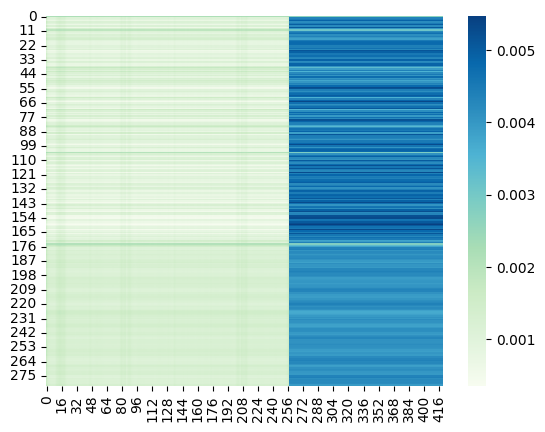


Epoch: 2/60


Val:  91%|█████████ | 20/22 [00:41<00:04,  2.01s/it, dist=481.9008]                                              

CONSIDERATIONS OF DELICACY SEEMED TO FORBID TAKING THIS LIBERTY EVEN WITH AN INTIMATE FRIEND
AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE STREET AND THE S
9357


	Train Loss 1.3845	 Learning Rate 0.0010000
	Val Dist 480.9187%


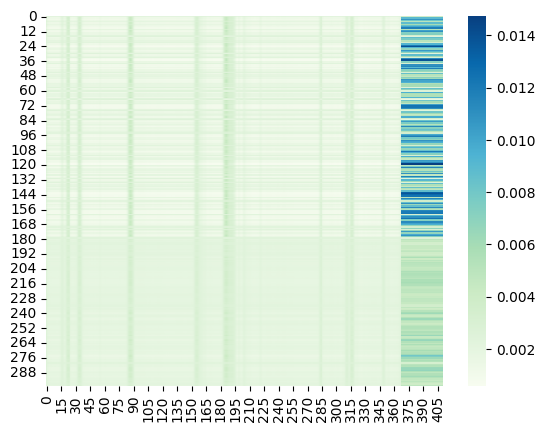


Epoch: 3/60


Val:  23%|██▎       | 5/22 [00:10<00:36,  2.14s/it, dist=472.8375]                                               

HE COULD HARDLY REALISE HOW IT HAD ALL COME ABOUT
AND THE STRANGE AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND TH
32800


Val:  45%|████▌     | 10/22 [00:20<00:25,  2.09s/it, dist=473.2109]

DORRIFORTH THEN LAID THE BOOK OUT OF HIS HAND AND BY THE TIME THE SERVANT HAD LEFT THE ROOM THUS BEGAN
AND THE STRANGE AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND THE STRAIGHT OF THE STREET AND TH
55402


	Train Loss 1.2764	 Learning Rate 0.0010000
	Val Dist 473.0524%


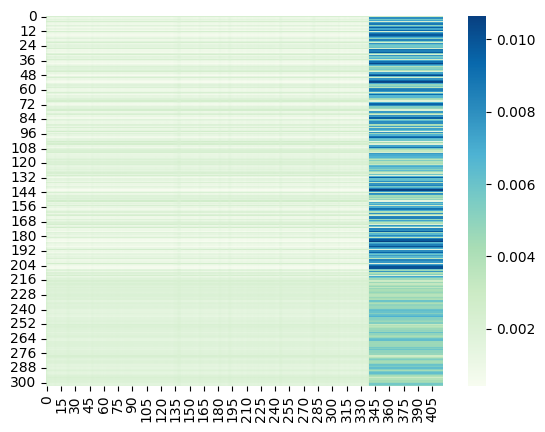


Epoch: 4/60


Val:   9%|▉         | 2/22 [00:04<00:43,  2.19s/it, dist=479.4297]                                               

IN ARISTOCRACIES EVERY MAN HAS ONE SOLE OBJECT WHICH HE UNCEASINGLY PURSUES BUT AMONGST DEMOCRATIC NATIONS THE EXISTENCE OF MAN IS MORE COMPLEX THE SAME MIND WILL ALMOST ALWAYS EMBRACE SEVERAL OBJECTS AT THE SAME TIME AND THESE OBJECTS ARE FREQUENTLY WHOLLY FOREIGN TO EACH OTHER AS IT CANNOT KNOW THEM ALL WELL THE MIND IS READILY SATISFIED WITH IMPERFECT NOTIONS OF EACH
AND THE SOUND OF THE SUBJECT WAS THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT 
53740


Val:  23%|██▎       | 5/22 [00:10<00:36,  2.13s/it, dist=476.0750]

THEN HE CALLED HARRY THE BOY OF ALL WORK AROUND THE PLACE
AND THE SUBJECT WAS THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY OF THE SUBJECT IN THE STORY 
35366


	Train Loss 1.2269	 Learning Rate 0.0010000
	Val Dist 476.3695%


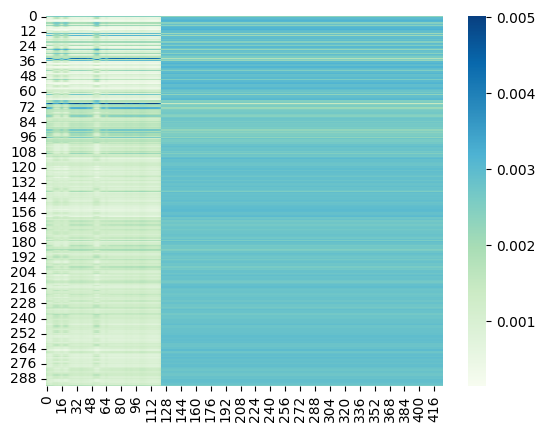


Epoch: 5/60


Val:   9%|▉         | 2/22 [00:04<00:44,  2.23s/it, dist=478.3906]                                               

YOU SEE THE TREATMENT IS A TRIFLE FANCIFUL
AND THE SAME THE SAME THING IS THE SAME THAT I HAVE NO DOUBT THAT I HAD NOT BEEN A STRANGE TO THE SAME TIME THE SAME THING I HAVE NO DOUBT THAT I HAD NOT BEEN A STRANGE TO THE SAME TIME THE SAME THING I HAVE NO DOUBT THAT I HAD NOT BEEN A STRANGE TO THE SAME TIME THE SAME THING I HAVE NO DOUBT THAT I HAD NOT BEEN A STRANGE TO THE SAME TIME THE SAME THING I HAVE NO DOUBT THAT I HAD NOT BEEN A STRANGE TO THE SAME TIME THE SAME THING I HAVE NO DOUBT THAT I HAD NOT BEEN A STRANGE TO THE SAME TIME THE SAME THING I HAVE NO DOUBT THAT I HAD NOT BEEN 
58334


Val:  23%|██▎       | 5/22 [00:10<00:35,  2.11s/it, dist=474.7063]

FOR SOME REASON HE FELT AS IF SOMETHING MIGHT COME THAT WAY AND WAS RELIEVED WHEN ALL THE ENVELOPES HAD BEEN SCANNED AND NOTHING SUSPICIOUS NOTICED
AND THE SAME THE SAME THING IS THE SAME THAT I HAVE NO DOUBT THAT I HAD NOT BEEN A STRANGE TO THE SAME TIME THE SAME THING I HAVE NO DOUBT THAT I WAS A MAN WHO WAS A MAN WHO WAS A MAN WHO WAS A MAN WHO WAS A STRANGE AND THE SAME THE SAME THE SAME THING IS THE SAME THAT I HAVE NO DOUBT THAT I HAD NOT BEEN A STRANGE TO THE SAME TIME THE SAME THING I HAVE NO DOUBT THAT I WAS A MAN WHO WAS A MAN WHO WAS A MAN WHO WAS A MAN WHO WAS A STRANGE AND THE SAME THE SAME THE SAME THING IS THE SAME THAT I HAVE NO DOUBT THAT I HAD NOT BEEN A STRANGE TO THE S
19157


	Train Loss 1.1932	 Learning Rate 0.0010000
	Val Dist 474.9294%


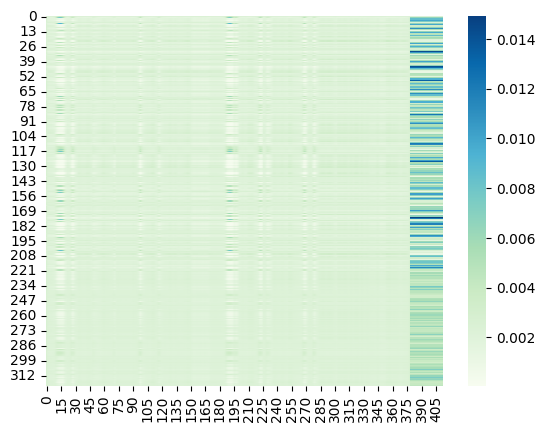


Epoch: 6/60


Val:   0%|          | 0/22 [00:00<?, ?it/s]                                                                      

MYSELF I ALWAYS KNEW SHE HAD IT IN HER
AND THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF
38275


Val:   9%|▉         | 2/22 [00:04<00:44,  2.21s/it, dist=481.3242]

THE WANDERING SINGER
AND THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF
53730


Val:  27%|██▋       | 6/22 [00:12<00:33,  2.11s/it, dist=478.0521]

AND OF COURSE I HAD MY EXPECTATIONS AND SHE HAD HERS
AND THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF
46893


Val:  82%|████████▏ | 18/22 [00:37<00:07,  1.98s/it, dist=478.1636]

THAT POOR BOY IS IN A VERY EXCITED STATE TO NIGHT SHE MURMURED AFTER A PAUSE WHICH LASTED FOR THREE TICKS OF THE CLOCK
AND THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF
17687


Val:  91%|█████████ | 20/22 [00:40<00:03,  1.95s/it, dist=478.9426]

WHENCE SHE TO ME IN THOSE DESIRES OF MINE WHICH LED THEE TO THE LOVING OF THAT GOOD BEYOND WHICH THERE IS NOTHING TO ASPIRE TO
AND THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF THE SAME TIME THE STREAM OF
41367


	Train Loss 1.1679	 Learning Rate 0.0010000
	Val Dist 477.9983%


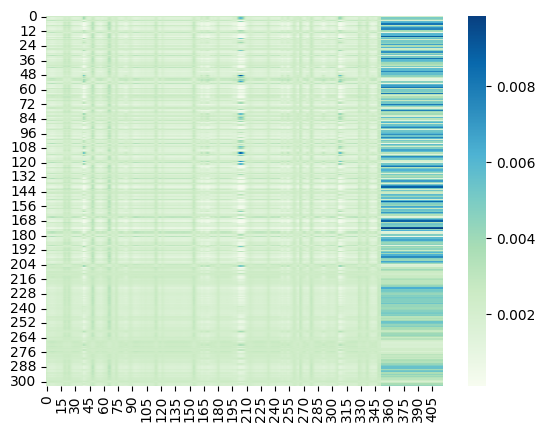


Epoch: 7/60


Val:  18%|█▊        | 4/22 [00:08<00:37,  2.06s/it, dist=479.0293]                                               

GRADUALLY RELIEF CAME TO ALL OF US
AND THE SAME THING THAT THE SAME TIME THE SAME THING THAT THE SAME TIME THE SAME THING THAT HE WAS A MAN OF THE SAME THAT THE SAME TIME THE STRANGER WAS A MAN OF THE SAME THAT THE SAME TIME THE STRANGER WAS A MAN OF THE SAME THAT THE SAME TIME THE STRANGER WAS A MAN OF THE SAME THAT THE SAME TIME THE STRANGER WAS A MAN OF THE SAME THAT THE SAME TIME THE STRANGER WAS A MAN OF THE SAME THAT THE SAME TIME THE STRANGER WAS A MAN OF THE SAME THAT THE SAME TIME THE STRANGER WAS A MAN OF THE SAME THAT THE SAME TIME THE STRANGER WAS A MAN OF THE SAME 
54763


Val:  23%|██▎       | 5/22 [00:10<00:35,  2.07s/it, dist=476.4937]

IT WAS WRITTEN IN THE UPPER RANGITATA DISTRICT OF THE CANTERBURY PROVINCE AS IT THEN WAS OF NEW ZEALAND AND APPEARED AT CHRISTCHURCH IN THE PRESS NEWSPAPER JUNE THIRTEENTH EIGHTEEN SIXTY THREE
AND THE SAME THING THAT THE SAME TIME THE SAME THING THAT HE WAS A MAN OF THE SAME THAT THE SAME TIME THE SAME THING THAT HE WAS A MAN OF THE SAME THAT THE SAME TIME THE SAME THING THAT HE WAS A MAN OF THE SAME THAT THE SAME TIME THE SAME THING THAT HE WAS A MAN OF THE SAME THAT THE SAME TIME THE SAME THING THAT HE WAS A MAN OF THE SAME THAT THE SAME TIME THE SAME THING THAT HE WAS A MAN OF THE SAME THAT THE SAME TIME THE SAME THING THAT HE WAS A MAN OF THE SAME THAT THE SAME TIME THE SAME THING THAT HE WAS A MAN OF THE SAME THAT THE SAME TIME
54514


	Train Loss 1.1478	 Learning Rate 0.0010000
	Val Dist 476.5568%


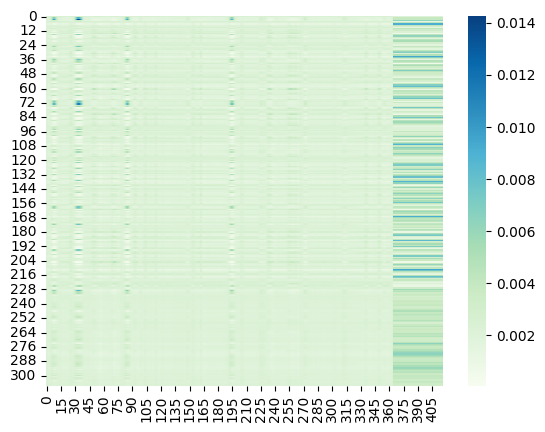


Epoch: 8/60


Val:  14%|█▎        | 3/22 [00:06<00:40,  2.15s/it, dist=478.3958]                                               

I FOLLOWED WITH THE SPADE OVER MY SHOULDER DRAGGING MY SNAKE
AND THE SUN WAS A STRANGE AND SHE HAD SEEN HER HEAD AND THE SHEEP WAS A STRANGER AND THE SHELF OF THE SHORE AND THE SHORE OF THE SHORE AND THE SHORE OF THE SHORE AND THE SHORE OF THE SHORE AND THE SHORE OF THE SHORE AND THE SHORE OF THE SHORE AND THE SHORE OF THE SHORE AND THE SHORE OF THE SHORE AND THE SHORE OF THE SHORE AND THE SHORE OF THE SHORE AND THE SHORE OF THE SHORE AND THE SHORE OF THE SHORE AND THE SHORE OF THE SHORE AND THE SHORE OF THE SHORE AND THE SHORE OF THE SHORE AND THE SHORE OF THE SHORE AND THE SHORE OF THE SHORE AND THE S
44880


Val:  27%|██▋       | 6/22 [00:12<00:33,  2.08s/it, dist=477.5000]

I HAVE ALWAYS DELIGHTED IN AND REVERENCED BEAUTY BUT I FELT SIMPLY ABASHED IN THE PRESENCE OF SUCH A SPLENDID TYPE A COMPOUND OF ALL THAT IS BEST IN EGYPTIAN GREEK AND ITALIAN
AND THE SUN WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STR
8806


Val:  73%|███████▎  | 16/22 [00:33<00:12,  2.03s/it, dist=477.3813]

BUT THE FACES OF THE MEN WERE ROSY AND THE GOBLETS BY THEM HAD A FEW DROPS OF WINE LEFT
AND THE SUN WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGER THAN THE SAME THAT HE HAD BEEN A STRANGER THAN THE SAME THAT HE HAD BEEN A STRANGER THAN THE SAME THAT HE HAD BEEN A STRANGER THAN THE SAME THAT HE HAD BEEN A STRANGER THAN THE SAME THAT HE HAD BEEN A STRANGER THAN THE SAME THAT HE HAD BEEN A STRANGER THAN THE SAME THAT HE HAD BEEN A STRANGER THAN THE SAME THAT HE HAD BEEN A STRANGER THAN THE SAME THAT HE HAD BEEN A STRANGER THAN THE SAME THAT HE HAD BEEN A STRANGER THAN THE SAME THAT HE HAD BEEN A STRANGER THAN THE SAME TH
33770


Val:  77%|███████▋  | 17/22 [00:35<00:10,  2.03s/it, dist=477.3258]

SURROUND WITH A GARNISH OF COOKED AND DICED CARROTS TURNIPS GREEN PEAS
AND THE SUN WAS A STRANGE AND STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND T
17397


Val:  91%|█████████ | 20/22 [00:41<00:04,  2.00s/it, dist=477.8859]

DANTE BECAUSE VIRGILIUS HAS DEPARTED DO NOT WEEP YET DO NOT WEEP YET AWHILE FOR BY ANOTHER SWORD THOU NEED'ST MUST WEEP
AND THE SUN WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STRANGE AND SHE WAS A STR
37104


THOU LIKE ARCTURUS STEADFAST IN THE SKIES WITH TARDY SENSE GUIDEST THY KINGDOM FAIR BEARING ALONE THE LOAD OF LIBERTY
AND THE SUN WAS A STRANGE AND STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND THE STREAM OF THE STREET AND T
7012
	Train Loss 1.1298	 Learning Rate 0.0010000
	Val Dist 476.9633%


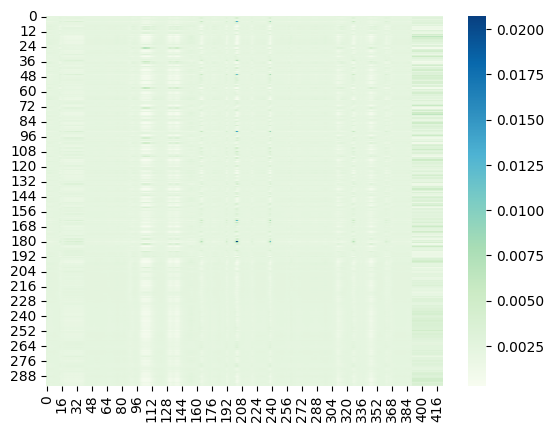


Epoch: 9/60


Val:  36%|███▋      | 8/22 [00:16<00:28,  2.03s/it, dist=487.4082]                                               

I TOOK QUITE A FANCY TO HIM WHY
AND THE STORY OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF
45439


Val:  50%|█████     | 11/22 [00:22<00:22,  2.07s/it, dist=485.6470]

IN FACT THE RINGLEADER JOHN REX GAVE ME HIS CONFESSION AND I SENT IT TO THE BISHOP
AND THE STORY OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF
55743


Val:  91%|█████████ | 20/22 [00:41<00:03,  2.00s/it, dist=486.5918]

D'AVRIGNY UNABLE TO BEAR THE SIGHT OF THIS TOUCHING EMOTION TURNED AWAY AND VILLEFORT WITHOUT SEEKING ANY FURTHER EXPLANATION AND ATTRACTED TOWARDS HIM BY THE IRRESISTIBLE MAGNETISM WHICH DRAWS US TOWARDS THOSE WHO HAVE LOVED THE PEOPLE FOR WHOM WE MOURN EXTENDED HIS HAND TOWARDS THE YOUNG MAN
AND THE STORY OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF THE STATE OF
14214


	Train Loss 1.1142	 Learning Rate 0.0010000
	Val Dist 485.6808%


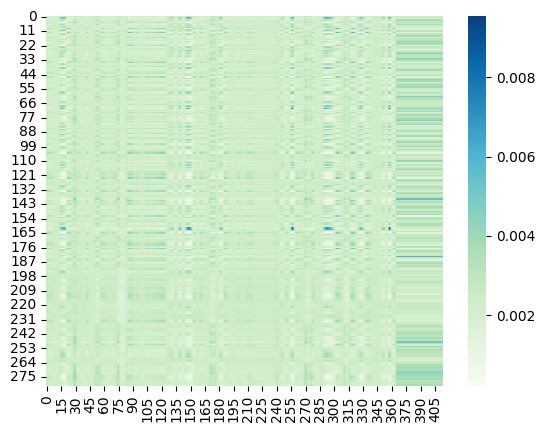


Epoch: 10/60


Val:  45%|████▌     | 10/22 [00:20<00:24,  2.03s/it, dist=454.9883]                                              

SHE WAS GOING TO REPLY BUT FOUND SHE COULD NOT WITHOUT ACCOMPANYING HER WORDS WITH TEARS THEREFORE AFTER THE FIRST ATTEMPT SHE DESISTED
AND THE SHORT SHOES OF THE SHORES OF THE SHORE WERE SHOWN AND THE SHORES OF THE SHORE WAS A SHORT TIME AND THE SHEEP WAS A SHORT TIME AND THE SHEEP WAS A SHORT TIME AND THE SHEEP WAS A SHORT TIME AND THE SHEEP WAS A SHORT TIME AND THE SHEEP WAS A SHORT TIME AND THE SHEEP WAS A SHORT TIME AND THE SHEEP WAS A SHORT TIME AND THE SHEEP WAS A SHORT TIME AND THE SHEEP WAS A SHORT TIME AND THE SHEEP WAS A SHORT TIME AND THE SHEEP WAS A SHORT TIME AND THE SHEEP WAS A SHORT TIME AND THE SHEEP WAS A SHORT TIME AND THE SHEEP WAS A SHORT TIME AND THE SHEE
54473


	Train Loss 1.0995	 Learning Rate 0.0010000
	Val Dist 457.2125%


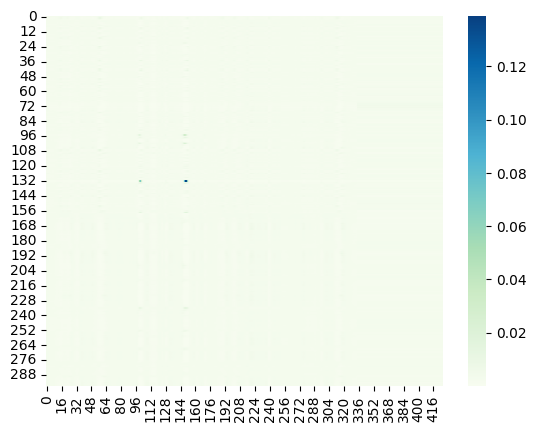


Epoch: 11/60


Val:  55%|█████▍    | 12/22 [00:25<00:21,  2.14s/it, dist=478.0736]                                              

THERE MUST BE A SORT OF REPUGNANCE IN ME TO BELIEVE ANYTHING DEFINITE ABOUT MYSELF IS THERE PERHAPS SOME ENIGMA THEREIN
AND THE SECOND HAD BEEN SEEN TO THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND T
2026


Val:  86%|████████▋ | 19/22 [00:39<00:05,  2.00s/it, dist=479.2171]

WITH A FEW LANTERNS OUR MEN THEN WENT ABOUT AND TRIED TO GATHER UP THE WOUNDED THE DEAD WERE LEFT TILL MORNING
AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE STRANGER AND THE SECRET OF THE 
3350
BUT IN REALITY HANSEL WAS NOT LOOKING AT A CAT BUT EVERY TIME HE STOPPED HE DROPPED A PEBBLE OUT OF HIS POCKET UPON THE PATH
AND THE SECOND HALF WAY OF THE SECOND AND THE SECOND OF THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA AND THE SEA A

	Train Loss 1.0861	 Learning Rate 0.0010000
	Val Dist 478.6972%


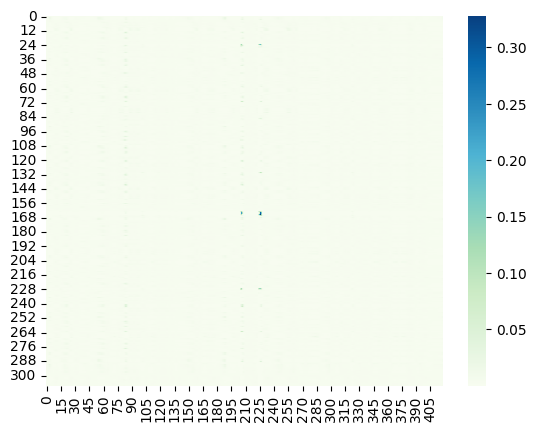


Epoch: 12/60


Val:  36%|███▋      | 8/22 [00:15<00:26,  1.86s/it, dist=427.2373]                                               

THE VIVID GREEN OF THE BOULDERS BENEATH THE WATER IS VERY STRIKING AND COLORS THE ENTIRE STREAM WITH THE EXCEPTION OF THE PORTIONS BROKEN INTO FOAM
AND THE SHADOW OF THE SHIP WAS A SHADOWY OF THE SHIP AND THE SHIP WAS A SHADOWY OF THE SHIP AND THE SHIP WAS A SHADOWY OF THE SHIP AND THE SHIP WAS A SHADOWY OF THE SHIP AND THE SHIP WAS A SHADOWY OF THE SHIP AND THE SHIP WAS A SHADOWY OF THE SHIP AND THE SHIP WAS A SHADOWY OF THE SHIP AND THE SHIP WAS A SHADOWY OF THE SHIP AND THE SHIP WAS A SHADOWY OF THE SHIP AND THE SHIP WAS A SHADOWY OF THE SHIP AND THE SHIP WAS A SHADOWY OF THE SHIP AND THE SHIP WAS A SHADOWY OF THE SHIP AND THE SHIP WAS A SHADOWY OF THE SHIP AND THE SHIP WAS A SHADOWY O
30134


Val:  50%|█████     | 11/22 [00:21<00:20,  1.90s/it, dist=423.7074]

IN FACT CONFORMABLY TO THE SLOW RISE OF THE DEMOCRATIC SOCIAL ORDER AND ITS CAUSE THE BLENDING OF THE BLOOD OF MASTERS AND SLAVES THE ORIGINALLY NOBLE AND RARE IMPULSE OF THE MASTERS TO ASSIGN A VALUE TO THEMSELVES AND TO THINK WELL OF THEMSELVES WILL NOW BE MORE AND MORE ENCOURAGED AND EXTENDED BUT IT HAS AT ALL TIMES AN OLDER AMPLER AND MORE RADICALLY INGRAINED PROPENSITY OPPOSED TO IT AND IN THE PHENOMENON OF VANITY THIS OLDER PROPENSITY OVERMASTERS THE YOUNGER
AND THE SUN WAS A LITTLE AND THE STORMY GIRL WAS A LITTLE AND THE STORMY GIRL WAS A LITTLE AND THE STORMY GIRL WAS A LITTLE AND THE STORMY GIRL WAS A LITTLE AND THE STORMY GIRL WAS A LITTLE AND THE STORMY GIRL WAS A LITTLE AND THE STORMY GIRL WAS A LITTLE AND THE STORMY GIRL WAS A LITTLE AND THE STORMY GIRL WAS A LITTLE AND THE STORMY GIRL WAS A LITTLE AND THE STORMY GIRL WAS A LITTLE AND THE STORMY GIRL WAS A LITTLE AND THE STORMY GIRL WAS A LITTLE AND THE STORMY GIRL WAS A LITTLE AND THE STORMY GIRL WAS A LITTLE AND THE STO

Val:  59%|█████▉    | 13/22 [00:25<00:17,  1.99s/it, dist=424.4093]

HE WAS WALKING ALONG WHEN ALL AT ONCE HE DROPPED DOWN AND DIED WITHOUT A STRUGGLE OR A GROAN
AND THE STRANGE CHILDREN WERE STRONG AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRANGE AND STRA
23644


Val:  86%|████████▋ | 19/22 [00:36<00:05,  1.86s/it, dist=429.2068]

NO BATTERY IN THE WHOLE FOUR YEARS WAR LOST SO MANY MEN IN SO SHORT A TIME
WHICH WAS A SHORT TIME AND THE SHORT STARTLED CONSTANT CONTRADICTION OF THE SHORT STATE OF THE SHORT STATE OF THE SHORT STATE OF THE SHORT TIME THE SUN WAS A SHORT DISTANCE AND THE SHORT STARTLED CARRIAGE WAS A SHORT DISTANCE AND THE SHORE OF THE SHORT STARTLED CARRIAGE WAS A SHORT DISTANCE AND THE SHORE OF THE SHORT STARTLED CARRIAGE WAS A SHORT DISTANCE AND THE SHORE OF THE SHORT STARTLED CARRIAGE WAS A SHORT DISTANCE AND THE SHORE OF THE SHORT STARTLED CARRIAGE WAS A SHORT DISTANCE AND THE SHORE OF THE SHORT STARTLED CARRIAGE WAS A SHORT DI
1952


	Train Loss 1.0713	 Learning Rate 0.0010000
	Val Dist 432.9044%


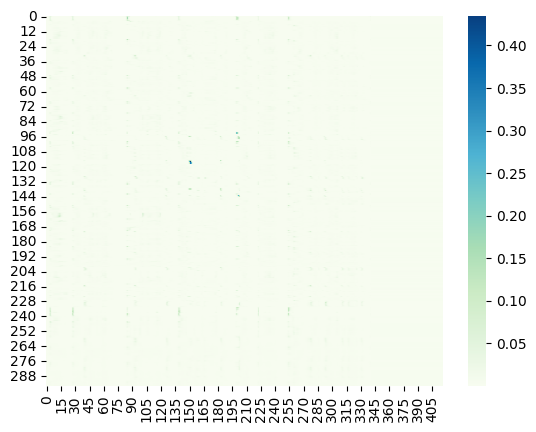


Epoch: 13/60


Val:  23%|██▎       | 5/22 [00:06<00:22,  1.31s/it, dist=180.1328]                                               

SINCE YOU ARE A FRIEND OF MY COUSIN HEPZIBAH'S YOU SHOULD ASK HER TO SHOW YOU THE PICTURE
SAID JOHN AFFECTS A BOOKSTALLER FRANK THAT I SHALL BE ASCRIBED TO SHAKE HANDS COME TO THE COMMISSION
24479


Val:  45%|████▌     | 10/22 [00:12<00:15,  1.27s/it, dist=175.4547]

NOBODY NEED HAVE ANY DOUBT ABOUT THAT SAID SANCHO FOR MY MASTER HAS A VERY HAPPY KNACK OF MATCHMAKING IT'S NOT MANY DAYS SINCE HE FORCED ANOTHER MAN TO MARRY WHO IN THE SAME WAY BACKED OUT OF HIS PROMISE TO ANOTHER MAIDEN AND IF IT HAD NOT BEEN FOR HIS PERSECUTORS THE ENCHANTERS CHANGING THE MAN'S PROPER SHAPE INTO A LACQUEY'S THE SAID MAIDEN WOULD NOT BE ONE THIS MINUTE
THE WIND HAD BEEN HEAVY AND EVEN YEAR THE GENERAL DEAD SAID THE READING OF THE SAME REASS THE ENGLISH THE SAME WAS THE SAME WAY BACK THE MAN IN THE SAME WAY BACK THE MAN IN THE SAME WAY BACK THE MAN IN THE SAME WAY BACK THE MAN IN THE SAME WAY BACK THE MAN IN THE SAME WAY BACK THE MAN IN THE SAME WAY BACK THE MAN IN THE SAME WAY BACK THE MAN IN THE SAME WAY BACK THE MAN IN THE SAME WAY BACK THE MAN IN THE SAME WAY BACK THE MAN IN THE SAME WAY BACK THE MAN IN THE SAME WAY BACK THE MAN IN THE SAME WAY BACK THE MAN IN THE SAME WAY BACK THE MAN IN
9426


Val:  82%|████████▏ | 18/22 [00:22<00:04,  1.15s/it, dist=173.5742]

THE SHADOW OF HIS EVIL GIFT CLUNG TO HIM YET LIKE THE SMELL OF A DEADLY DRUG IN AN OLD VIAL OF POISON EMPTIED NOW USELESS READY TO BE THROWN AWAY UPON THE RUBBISH HEAP OF THINGS THAT HAD SERVED THEIR TIME
THE SHADOW OF A SHADOW GATHER CONTINUED CONTEMPT HE HAD HEARD THE HOUR AND HE HAD HEARD HIM
23397


	Train Loss 0.9926	 Learning Rate 0.0010000
	Val Dist 172.0555%


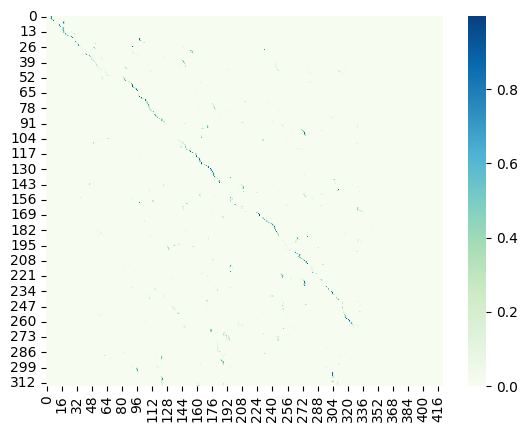


Epoch: 14/60


	Train Loss 0.5245	 Learning Rate 0.0010000
	Val Dist 69.8745%


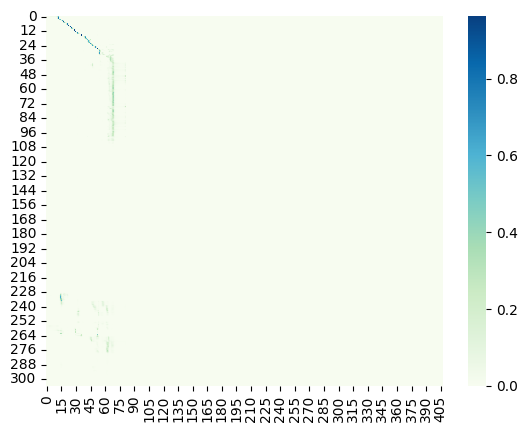


Epoch: 15/60


Train:  15%|█▍        | 33/223 [00:40<03:51,  1.22s/it, loss=0.3716, lr=0.0010, perplexity=1.4597, tf_rate=1.00]

KeyboardInterrupt: 

In [33]:
best_lev_dist = float("inf")
tf_rate = 1.0

for epoch in range(0, config['epochs']):

    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))
    config['epoch'] = epoch

    curr_lr = float(optimizer.param_groups[0]['lr'])

    teacher_forcing_ratio = 1

    if epoch >= 20:
        teacher_forcing_ratio = 1 - 0.5 * (epoch - 10) / config['epochs']

    # Call train and validate, get attention weights from training
    train_loss, running_perplexity, attention_plot = train(model, train_loader, criterion, optimizer, teacher_forcing_ratio)
    valid_dist = validate(model, val_loader, VOCAB)

    # Print your metrics
    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
    print("\tVal Dist {:.04f}%".format(valid_dist))

    # Call train and validate, get attention weights from training

    # Print your metrics

    # Plot Attention for a single item in the batch
    plot_attention(attention_plot[0].cpu().detach().numpy())

    # Log metrics to Wandb

    # Optional: Scheduler Step / Teacher Force Schedule
    scheduler.step()


    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        # Save your model checkpoint here

# Testing

In [45]:
# Optional: Load your best model Checkpoint here

# TODO: Create a testing function similar to validation
# TODO: Create a file with all predictions
# TODO: Submit to Kaggle
import pandas as pd
config['training'] = False
model.eval()

result = []
print(len(test_loader))
for data in tqdm(test_loader):
# for data in test_loader:
    x, lx = data
    x       = x.to(DEVICE)
    with torch.no_grad():
        raw_predictions, attentions = model(x, lx)

    # prediction_string= decode_prediction(h, lh, test_decoder)
    greedy_predictions   = torch.argmax(raw_predictions, dim=2) # TODO: How do you get the most likely character from each distribution in the batch?
    # print(greedy_predictions)
    # print(prediction_string[0][0])
    #TODO save the output in results array.
    batch_size, seq_len = greedy_predictions.shape

    for batch_idx in range(batch_size):

        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], VOCAB)

        # Strings - When you are using characters from the AudioDataset
        pred_string = ''.join(pred_sliced)
        result.append(pred_string)
        # Comment the above and uncomment below for toy dataset, as the toy dataset has a list of phonemes to compare
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)


    # for i in greedy_predictions:
    #   result.append(i)

    del x, lx, raw_predictions, attentions
    torch.cuda.empty_cache()




21


/tmp/ipykernel_1004756/1381252587.py:79: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x_lens = x_lens // 2
100%|██████████| 21/21 [00:14<00:00,  1.41it/s]


In [46]:
print(result[10])

# if param['submit']:

if True:
    sub = result
    # sub = []
    idx = []
    for i in range(len(result)):
    #     st = ""
    #     for j in range(len(result[i])):
    #         # print(result[i][j])
    #         st += VOCAB_MAP[result[i][j]]
    #     sub.append(st)
        idx.append(i)
    # print(len(sub))
    # data_dir = "/content/sample_data" + "/random_submission.csv"
    # df = pd.read_csv(data_dir)
    # print(type(results[0][0]))
    df = pd.DataFrame({'index':idx, 'label':sub})
    df.to_csv('submission.csv', index = False)

    # !kaggle competitions submit -c 11-785-s23-hw4p2 -f submission.csv -m "I made it!"

WELL NOW INNOCED I DECLARE YOU HAVE A HEAD AND SO HAS MY STICK
